## **Data**

In [2]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

#фильтруем фичи (дата) по значению классификационных лэйблов (таргет), берем или цифру 3 или цифру 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
#тоже самое для тестового набора
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
#необходимы препроцессинг лейблов, видимо не все значения имею тип integer, а нам нужен именно этот тип функция лонг позволяет нам 
#        это сделать (self.long() is equivalent to self.to(torch.int64). See to())
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## **Perc**

In [3]:
learning_rate = 0.01
epochs = 5
b_s = 128

in_feat = 524  # inp * 2/3 + outp
n_feat = 784

w1 = np.random.rand(n_feat, in_feat) * learning_rate
b1 = np.zeros(in_feat)
w2 = np.random.rand(in_feat, 1) * learning_rate
b2 = np.zeros(1)

losses = []

def sigm(x):
  return 1 / (1 + np.exp(-x))

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)


        if x.shape[0] != b_s:
          continue

        # forward
        z1 = x.dot(w1) + b1
        a1 = sigm(z1)
        z2 = a1.dot(w2) + b2
        p = sigm(z2)

        # рассчет bce
        bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / b_s
        losses.append(bce)

        # backward
        dp = (p - y) / b_s

        da1_dz1 = 1 - ((np.exp(z1) - np.exp(-z1)) / (np.exp(z1) + np.exp(-z1)))
        w2_da1_dz1 = np.multiply(w2.T, da1_dz1)

        dp_w2_da1_dz1 = np.multiply(dp, w2_da1_dz1)

        dloss_dw1 = np.dot(x.T, dp_w2_da1_dz1)
        dloss_db1 = np.dot(np.ones(b_s), dp_w2_da1_dz1)
        dloss_dw2 = np.dot(a1.T, dp)
        dloss_db2 = np.dot(np.ones((1, b_s))[0], dp)

        w1 -= learning_rate * dloss_dw1
        b1 -= learning_rate * dloss_db1
        w2 -= learning_rate * dloss_dw2
        b2 -= learning_rate * dloss_db2
        

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


## **Plot**

Text(0, 0.5, 'Loss function')

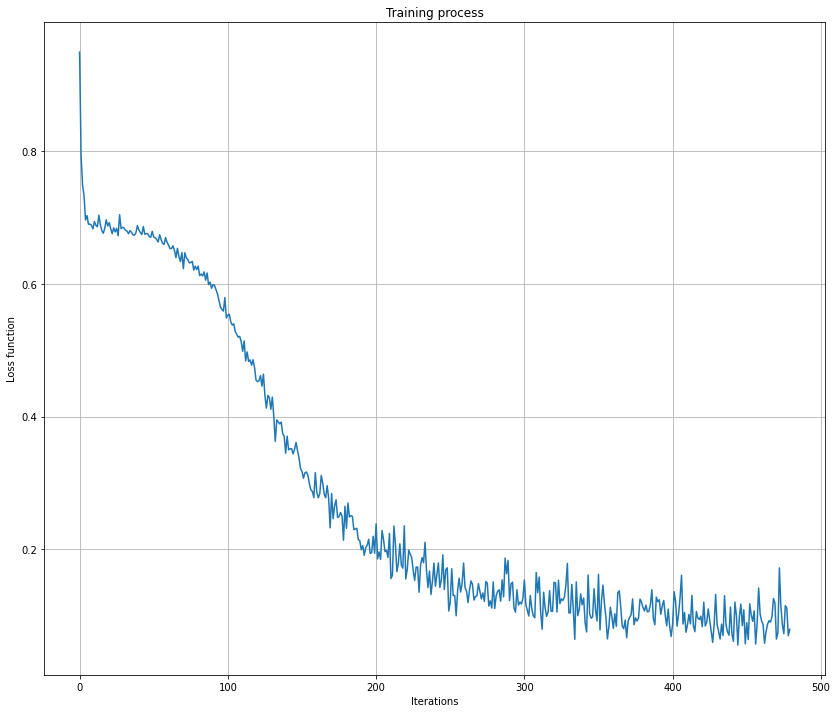

In [4]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

## **Test**

In [6]:
from sklearn.metrics import f1_score

losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

    x = x.view(x.shape[0], -1).numpy()
    y = np.expand_dims(y.numpy(), 1)

    if x.shape[0] != b_s:
        continue
        
    z1 = x.dot(w1) + b1
    a1 = sigm(z1)
    z2 = a1.dot(w2) + b2    
    p = sigm(z2)

    bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / b_s
    losses.append(bce)
        
    losses_test.append(bce)
    predicted.extend(p)
    true_lbls.extend(y) 

print(len(predicted), len(true_lbls))

pred = np.array([round(i[0]) for i in predicted]) 
# У нас были вероятности а нужны классы поэтому просто округлим каждое значени и получим лейблы 
t_lbls = np.array(true_lbls).squeeze() #снимем лишнюю размерность
f1 = f1_score(pred, t_lbls, average='weighted')

print('F1 score is equal to: {0:0.02f}'.format(f1))

1920 1920
F1 score is equal to: 0.97
